In [1]:
import os
import tempfile
import time
from datetime import datetime, timedelta
from os import path

import contextily as cx
import geopandas as gpd
import pandas as pd
import seaborn as sns
import tqdm
import xvec
import xarray as xr
from meteostations.clients import agrometeo

import tstore

/home/martibosch/mambaforge/envs/tstore/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Consider 1 month of meteorological stations data. How would you represent it in a tabular format?

In [2]:
region = "Canton de Vaud"
variables = ["temperature", "water_vapour", "precipitation"]
start_date = "2021-01-01"
end_date = "2021-01-31"

client = agrometeo.AgrometeoClient(region)

# ax = client.stations_gdf.plot()
# cx.add_basemap(ax=ax, crs=client.stations_gdf.crs, attribution="")
# 
ts_df = client.get_ts_df(variables, start_date, end_date)
ts_df

station                     1                                      3    \
variable            temperature water_vapour precipitation temperature   
time                                                                     
2021-01-01 00:00:00         2.2         99.0           0.2         2.5   
2021-01-01 00:10:00         2.3         99.0           0.2         2.6   
2021-01-01 00:20:00         2.4         99.0           0.1         2.8   
2021-01-01 00:30:00         2.4         99.0           0.2         2.8   
2021-01-01 00:40:00         2.5         99.0           0.2         2.8   
...                         ...          ...           ...         ...   
2021-01-31 23:10:00         5.7         99.0           0.0         6.6   
2021-01-31 23:20:00         5.9         99.0           0.4         6.6   
2021-01-31 23:30:00         6.1         99.0           0.2         6.5   
2021-01-31 23:40:00         6.1         98.0           0.3         6.5   
2021-01-31 23:50:00         6.1         99.0           0.3         6.5   

station                                                4                 \
variable            water_vapour precipitation temperature water_vapour   
time                                                                      
2021-01-01 00:00:00         96.0           0.0         2.3         94.0   
2021-01-01 00:10:00         96.0           0.2         2.4         94.0   
2021-01-01 00:20:00         95.0           0.1         2.4         94.0   
2021-01-01 00:30:00         94.0           0.2         2.4         94.0   
2021-01-01 00:40:00         94.0           0.1         2.5         94.0   
...                          ...           ...         ...          ...   
2021-01-31 23:10:00         93.0           0.5         5.7         96.0   
2021-01-31 23:20:00         94.0           0.4         6.0         95.0   
2021-01-31 23:30:00         94.0           0.4         6.1         95.0   
2021-01-31 23:40:00         95.0           0.3         6.2         94.0   
2021-01-31 23:50:00         96.0           0.9         6.2         94.0   

station                                   10   ...           98          99   \
variable            precipitation temperature  ... precipitation temperature   
time                                           ...                             
2021-01-01 00:00:00           0.2         3.2  ...           0.5         0.1   
2021-01-01 00:10:00           0.2         3.1  ...           0.4         0.0   
2021-01-01 00:20:00           0.2         3.3  ...           0.2        -0.0   
2021-01-01 00:30:00           0.2         3.1  ...           0.3         0.0   
2021-01-01 00:40:00           0.2         3.0  ...           0.3         0.1   
...                           ...         ...  ...           ...         ...   
2021-01-31 23:10:00           0.0         5.7  ...           0.1         5.6   
2021-01-31 23:20:00           0.6         5.8  ...           0.4         5.6   
2021-01-31 23:30:00           0.2         6.0  ...           0.0         5.7   
2021-01-31 23:40:00           0.4         5.8  ...           0.2         5.4   
2021-01-31 23:50:00           0.2         6.0  ...           0.2         5.3   

station                                                301               \
variable            water_vapour precipitation temperature water_vapour   
time                                                                      
2021-01-01 00:00:00        100.0           0.0         0.3        100.0   
2021-01-01 00:10:00        100.0           0.0         0.3        100.0   
2021-01-01 00:20:00        100.0           0.0         0.2        100.0   
2021-01-01 00:30:00        100.0           0.0         0.2        100.0   
2021-01-01 00:40:00        100.0           0.0         0.2        100.0   
...                          ...           ...         ...          ...   
2021-01-31 23:10:00        100.0           0.1         6.6         88.0   
2021-01-31 23:20:00        100.0         

The above is the "wide form" data, where columns and rows contain levels of a variable.

In [3]:
long_ts_df = ts_df.stack(level=0, future_stack=True).swaplevel().sort_index()
long_ts_df

variable                     temperature  water_vapour  precipitation
station time                                                         
1       2021-01-01 00:00:00          2.2          99.0            0.2
        2021-01-01 00:10:00          2.3          99.0            0.2
        2021-01-01 00:20:00          2.4          99.0            0.1
        2021-01-01 00:30:00          2.4          99.0            0.2
        2021-01-01 00:40:00          2.5          99.0            0.2
...                                  ...           ...            ...
305     2021-01-31 23:10:00          7.0          80.0            0.0
        2021-01-31 23:20:00          7.1          78.0            0.1
        2021-01-31 23:30:00          6.9          80.0            0.0
        2021-01-31 23:40:00          6.9          81.0            0.0
        2021-01-31 23:50:00          6.8          82.0            0.2

[147312 rows x 3 columns]

In [4]:
# need this to replace station ids in coords
# cannot do it inline yet, see https://github.com/pydata/xarray/issues/6377
station_gser = client.stations_gdf.geometry

ts_ds = long_ts_df.to_xarray()
ts_ds.coords["station"]  = [station_gser[station_id] for station_id in ts_ds.coords["station"].astype(station_gser.index.dtype).values]
ts_ds = ts_ds.xvec.set_geom_indexes("station", crs=station_gser.crs)
ts_ds

<xarray.Dataset> Size: 4MB
Dimensions:        (station: 33, time: 4464)
Coordinates:
  * time           (time) datetime64[ns] 36kB 2021-01-01 ... 2021-01-31T23:50:00
  * station        (station) object 264B POINT (521720 148080) ... POINT (550...
Data variables:
    temperature    (station, time) float64 1MB 2.2 2.3 2.4 2.4 ... 6.9 6.9 6.8
    water_vapour   (station, time) float64 1MB 99.0 99.0 99.0 ... 80.0 81.0 82.0
    precipitation  (station, time) float64 1MB 0.2 0.2 0.1 0.2 ... 0.0 0.0 0.2
Indexes:
    station  GeometryIndex (crs=EPSG:21781)

The advantage of `xvec` is that we can efficiently perform both time series operations on the time index and spatial operations on the station index. Let us for instance filter to keep only the stations that are within 10km of Lausanne's city center:

In [5]:
buffer_dist = 10e3
query_geom = gpd.tools.geocode("Lausanne").to_crs(station_gser.crs).buffer(buffer_dist)
result = ts_ds.xvec.query(
    "station",
    query_geom,
)

We can now plot the spatial operation performed:

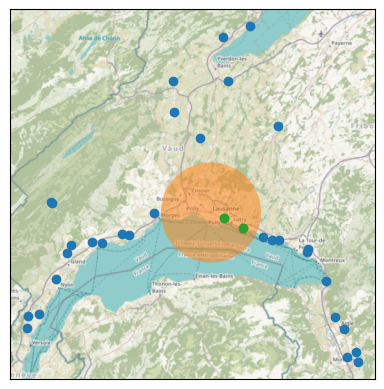

In [6]:
colors = sns.color_palette(n_colors=3)
ax = station_gser.plot(color=colors[0])
cx.add_basemap(ax=ax, crs=station_gser.crs, attribution="")
query_geom.plot(ax=ax, color=colors[1], alpha=.5)
gpd.GeoSeries(result.station, crs=station_gser.crs).plot(ax=ax, color=colors[2])
# ax.tick_params(axis="x", labelrotation=45)
for axis in ["x", "y"]:
    _ = getattr(ax, f"set_{axis}ticks")([])

However, there are two issues with xvec:

* we cannot use it if our time series data is not aligned
* There is no disk storage solution that is efficient, long-term/reliable and cross-platform, see [xec/issues/26](https://github.com/xarray-contrib/xvec/issues/26)

# Enter TStore

Let us now see how TStore can support our use case. We will start by assembling a data frame of 5 years of 10-min data.

## Example TStore: 5 years of 10-min data

(it may take a while to process all the requests)

In [7]:
num_years = 5
# https://pandas.pydata.org/docs/user_guide/timeseries.html#period-aliases
freq = "1MS"

yesterday = datetime.now().replace(
    hour=0,
    minute=0,
    second=0,
    microsecond=0,
) - timedelta(days=1)
date_range = pd.date_range(
    yesterday - timedelta(days=365 * num_years),
    yesterday,
    freq=freq,
)

ts_df = pd.concat(
    [
        client.get_ts_df(variables, start_date, end_date - timedelta(days=1))
        for start_date, end_date in tqdm.tqdm(
            zip(date_range[:-1], date_range[1:]),
            total=len(date_range) - 1,
        )
    ],
)
ts_df

100%|█████████████████████████████████████████████████| 59/59 [00:53<00:00,  1.10it/s]


station                     1                                      3    \
variable            temperature water_vapour precipitation temperature   
time                                                                     
2019-06-01 00:00:00        17.0         57.0           0.0        13.4   
2019-06-01 00:10:00        16.5         60.0           0.0        13.3   
2019-06-01 00:20:00        16.3         59.0           0.0        12.9   
2019-06-01 00:30:00        16.3         60.0           0.0        13.3   
2019-06-01 00:40:00        15.7         64.0           0.0        12.8   
...                         ...          ...           ...         ...   
2024-04-30 23:10:00        13.6         71.0           0.0        13.1   
2024-04-30 23:20:00        13.6         69.0           0.0        12.8   
2024-04-30 23:30:00        13.1         73.0           0.0        12.3   
2024-04-30 23:40:00        12.3         78.0           0.0        12.2   
2024-04-30 23:50:00        12.1         82.0           0.0        12.1   

station                                                4                 \
variable            water_vapour precipitation temperature water_vapour   
time                                                                      
2019-06-01 00:00:00         74.0           0.0        15.7         63.0   
2019-06-01 00:10:00         74.0           0.0        15.1         65.0   
2019-06-01 00:20:00         76.0           0.0        14.6         67.0   
2019-06-01 00:30:00         73.0           0.0        14.4         68.0   
2019-06-01 00:40:00         76.0           0.0        14.4         74.0   
...                          ...           ...         ...          ...   
2024-04-30 23:10:00         80.0           0.0        12.1         83.0   
2024-04-30 23:20:00         80.0           0.0        11.8         82.0   
2024-04-30 23:30:00         82.0           0.0        11.9         80.0   
2024-04-30 23:40:00         82.0           0.0        11.7         81.0   
2024-04-30 23:50:00         81.0           0.0        11.4         81.0   

station                                   10   ...           98          99   \
variable            precipitation temperature  ... precipitation temperature   
time                                           ...                             
2019-06-01 00:00:00           0.0        15.5  ...           0.0        14.5   
2019-06-01 00:10:00           0.0        15.2  ...           0.0        14.5   
2019-06-01 00:20:00           0.0        15.1  ...           0.0        14.3   
2019-06-01 00:30:00           0.0        14.9  ...           0.0        14.6   
2019-06-01 00:40:00           0.0        14.6  ...           0.0        14.8   
...                           ...         ...  ...           ...         ...   
2024-04-30 23:10:00           0.0        13.2  ...           0.0        13.0   
2024-04-30 23:20:00           0.0        13.3  ...           0.0        13.0   
2024-04-30 23:30:00           0.0        13.0  ...           0.0        12.3   
2024-04-30 23:40:00           0.0        12.8  ...           0.0        13.4   
2024-04-30 23:50:00           0.0        13.1  ...           0.0        12.9   

station                                                301               \
variable            water_vapour precipitation temperature water_vapour   
time                                                                      
2019-06-01 00:00:00         65.0           0.0        15.0         75.0   
2019-06-01 00:10:00         64.0           0.0        14.9         75.0   
2019-06-01 00:20:00         66.0           0.0        15.1         75.0   
2019-06-01 00:30:00         65.0           0.0        14.9         77.0   
2019-06-01 00:40:00         63.0           0.0        14.6         80.0   
...                          ...           ...         ...          ...   
2024-04-30 23:10:00         74.0           0.0        12.7         80.0   
2024-04-30 23:20:00         74.0         

Let us convert the wide data frame above to a long data frame (writing to a TStore from a wide data frame is not supported yet):

In [8]:
long_ts_df = ts_df.stack(level=0, future_stack=True).swaplevel().sort_index()
long_ts_df

variable                     temperature  water_vapour  precipitation
station time                                                         
1       2019-06-01 00:00:00         17.0          57.0            0.0
        2019-06-01 00:10:00         16.5          60.0            0.0
        2019-06-01 00:20:00         16.3          59.0            0.0
        2019-06-01 00:30:00         16.3          60.0            0.0
        2019-06-01 00:40:00         15.7          64.0            0.0
...                                  ...           ...            ...
305     2024-04-30 23:10:00         14.4          84.0            0.0
        2024-04-30 23:20:00         14.9          74.0            0.0
        2024-04-30 23:30:00         14.9          74.0            0.0
        2024-04-30 23:40:00         15.3          69.0            0.0
        2024-04-30 23:50:00         15.3          67.0            0.0

[8534361 rows x 3 columns]

## Dump long data frame into a TStore

We will now dump the above long data frame into a TStore, but before we will dump it to a CSV file so that we can compare disk usage and processing times.

### Interlude: CSV comparison to have a baseline

In [9]:
with tempfile.TemporaryDirectory() as tmp_dir:
    csv_filepath = path.join(tmp_dir, "foo.csv")
    start = time.time()
    long_ts_df.to_csv(csv_filepath)
    print(f"Dumped csv in: {time.time() - start:.2f} s")
    print(f"Total size: {path.getsize(csv_filepath)/1e6} MB")
    start = time.time()
    pd.read_csv(csv_filepath)
    print(f"Read csv in: {time.time() - start:.2f} s")

Dumped csv in: 204.15 s
Total size: 310.489551 MB
Read csv in: 6.46 s


Now dump into a TStore:

In [15]:
def get_tstore_filepaths(base_dir):
    return [
        path.join(dp, f) for dp, dn, filenames in os.walk(base_dir) for f in filenames
    ]


tstore_dir = "agrometeo-tstore"
tstore_structure = "id-var"
id_var = "station"
time_var = "time"
# ts_variables = ["temperature", "water_vapour", "precipitation"]
ts_variables = {"cont": ["temperature", "water_vapour"], "sparse": ["precipitation"]}
partitioning = "year"

tslong = tstore.TSLong(long_ts_df.reset_index())
start = time.time()
tslong.to_tstore(
    # TSTORE options
    tstore_dir,
    # DFLONG attributes
    id_var,
    time_var,
    ts_variables,
    # TSTORE options
    partitioning=partitioning,
    tstore_structure=tstore_structure,
    overwrite=True,
)
print(f"Dumped tstore in: {time.time() - start:.2f} s")
tstore_filepaths = get_tstore_filepaths(tstore_dir)
for line in tstore_filepaths[:5] + ["..."] + tstore_filepaths[-5:]:
    if line.endswith("parquet"):
        print(line, f"({path.getsize(line)/1e6} MB)")
    else:
        print(line)

total_size = sum(path.getsize(tstore_filepath) for tstore_filepath in tstore_filepaths)
print(f"Total size: {total_size/1e6} MB (in {len(tstore_filepaths)} files)")

Dumped tstore in: 4.91 s
agrometeo-tstore/tstore_metadata.yaml
agrometeo-tstore/_attributes.parquet (0.001356 MB)
agrometeo-tstore/96/sparse/_common_metadata
agrometeo-tstore/96/sparse/_metadata
agrometeo-tstore/96/sparse/year=2020/part-0.parquet (0.483242 MB)
...
agrometeo-tstore/27/cont/year=2021/part-0.parquet (0.573812 MB)
agrometeo-tstore/27/cont/year=2019/part-0.parquet (0.337639 MB)
agrometeo-tstore/27/cont/year=2022/part-0.parquet (0.577302 MB)
agrometeo-tstore/27/cont/year=2023/part-0.parquet (0.579434 MB)
agrometeo-tstore/27/cont/year=2024/part-0.parquet (0.193246 MB)
Total size: 172.35335 MB (in 530 files)


We can now read the whole TStore into a `TSLong` object:

In [11]:
start = time.time()
tslong_df = tstore.open_tslong(tstore_dir)
print(f"Read tstore into TSLong into: {time.time() - start:.2f} s")
tslong_df

Read tstore into TSLong into: 26.43 s


,station,temperature,time,water_vapour,precipitation
0,96,25.6,2022-08-16 13:20:00,41.0,0.0
1,96,25.9,2022-08-16 13:30:00,41.0,0.0
2,96,26.1,2022-08-16 13:40:00,40.0,0.0
3,96,26.5,2022-08-16 13:50:00,39.0,0.0
4,96,26.8,2022-08-16 14:00:00,38.0,0.0
...,...,...,...,...,...
8534356,96,2.8,2020-12-31 23:10:00,88.0,0.0
8534357,96,3.1,2020-12-31 23:20:00,82.0,0.0
8534358,96,3.4,2020-12-31 23:30:00,77.0,0.0
8534359,96,3.0,2020-12-31 23:40:00,80.0,0.1


or read a single variable (in which case reading times are dramatically reduced):

In [18]:
variable = "sparse"
start = time.time()
T_ts_df = tstore.open_tslong(tstore_dir, ts_variables=variable)
print(f"Read tstore for {variable} into TSLong in: {time.time() - start:.2f} s")
T_ts_df

Read tstore for sparse into TSLong in: 2.24 s


,station,precipitation,time
0,96,0.0,2020-08-15 13:10:00
1,96,0.0,2020-08-15 13:20:00
2,96,0.0,2020-08-15 13:30:00
3,96,0.0,2020-08-15 13:40:00
4,96,0.0,2020-08-15 13:50:00
...,...,...,...
8534356,27,0.0,2023-12-31 23:10:00
8534357,27,0.0,2023-12-31 23:20:00
8534358,27,0.0,2023-12-31 23:30:00
8534359,27,0.0,2023-12-31 23:40:00


Or we can now lazily read the whole TStore into a `TSDF` object:

In [13]:
tsdf = tstore.open_tsdf(tstore_dir)
tsdf

,temperature,water_vapour,precipitation
station,,,
1,TS[shape=(Delayed('int-c5ff406e-b5aa-45ab-8b82...,TS[shape=(Delayed('int-48affc4c-861a-4afa-a244...,TS[shape=(Delayed('int-0b93ff86-6469-4670-b8ad...
3,TS[shape=(Delayed('int-3f94693f-5a75-4340-a0c4...,TS[shape=(Delayed('int-3fa5db7f-3663-41ac-96d3...,TS[shape=(Delayed('int-326449a6-0dd5-4591-9f11...
4,TS[shape=(Delayed('int-f9473a0d-4fc1-4172-8004...,TS[shape=(Delayed('int-abc71681-24c6-4944-b5a8...,TS[shape=(Delayed('int-ccc82c3b-5c8b-40a4-abeb...
10,TS[shape=(Delayed('int-5f9c74e2-d79a-45e4-990d...,TS[shape=(Delayed('int-197037ff-4571-4237-9a4a...,TS[shape=(Delayed('int-42e0d45c-01ff-4b71-a301...
13,TS[shape=(Delayed('int-1d37d40a-e31d-4db5-a0ce...,TS[shape=(Delayed('int-ab3ccdd2-d317-43a0-992e...,TS[shape=(Delayed('int-b61a7d70-b69e-4395-be76...
16,TS[shape=(Delayed('int-c9195184-e7ef-4c9f-9d34...,TS[shape=(Delayed('int-beabea60-7b66-42ab-a034...,TS[shape=(Delayed('int-2b41c592-db5f-474d-bab6...
22,TS[shape=(Delayed('int-46006a1a-9d5e-42ca-baf0...,TS[shape=(Delayed('int-7f2016db-01c1-46a4-931d...,TS[shape=(Delayed('int-b2af838a-71a9-455a-b5b0...
27,TS[shape=(Delayed('int-2535b492-3275-42e4-b3db...,TS[shape=(Delayed('int-5e6672dd-2264-45c2-bfc7...,TS[shape=(Delayed('int-a65f6b4b-47e3-4550-8fad...
29,TS[shape=(Delayed('int-686d678a-1d86-4642-bb02...,TS[shape=(Delayed('int-2604c26b-55a2-426d-be92...,TS[shape=(Delayed('int-13fb7f92-21ea-496a-8293...


and use the `TS.data.compute()` method after selecting the target data, so that only the required files are read:

In [14]:
station_id = "1"
variable = "precipitation"

start = time.time()
prec_ts_df = tsdf.loc[station_id, variable].data.compute()
print(f"Read tstore for station {station_id} and {variable} in: {time.time() - start:.2f} s")
prec_ts_df

Read tstore for station 1 and precipitation in: 0.30 s


variable,precipitation,time
0,0.0,2019-06-01 00:00:00
1,0.0,2019-06-01 00:10:00
2,0.0,2019-06-01 00:20:00
3,0.0,2019-06-01 00:30:00
4,0.0,2019-06-01 00:40:00
...,...,...
17414,0.0,2024-04-30 23:10:00
17415,0.0,2024-04-30 23:20:00
17416,0.0,2024-04-30 23:30:00
17417,0.0,2024-04-30 23:40:00
